
# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and its variations. You will learn how to encode images into latent vectors follow gaussian distribution, and how to control images decoded from latent spaces with condtional variational autoencoder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, one_hot

ModuleNotFoundError: No module named 'visualize_util'

In [ ]:
#Use this if you are running on any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Load MNIST Dataset

In [4]:
# TODO
input_dim = 28*28
hidden_dim = 400
latent_dim = 20
batch_size = 128
n_epochs = 10
# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor()])

num_classes = 10
portioned_img_size = 14*14

mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True)

mnist_test = datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True, train=False)

loader_test = DataLoader(mnist_test, batch_size=batch_size,
                          shuffle=True, drop_last=True)                        

In [73]:
class myVAE(nn.Module):
    def __init__(self, latent_dim):
        super(myVAE, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.batchnorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.batchnorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.batchnorm2d(128),
            nn.ReLU()
        )
             
        self.mean_layer = nn.Linear(self.encode_size, latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        self.logvar_layer = nn.Linear(self.encode_size, latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        

        # input: (N, Z) -> output: (N,1,H,W)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.batchnorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.batchnorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )  
           
    def forward(self, x):
        encoded = self.encoder(x)
        
        encoded_size = encoded.size()
        encoded_size = torch.prod(torch.tensor(encoded_size))

        mu = nn.Linear(encoded_size, latent_dim)(encoded)
        logvar = nn.Linear(encoded_size, latent_dim)(encoded)

        z = self.reparametrize(mu, logvar)            
        x_hat = self.decoder(z)

        return x_hat, mu, logvar

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def loss_function(self, x_hat, x, mu, logvar):
        KL_loss = -0.5 * torch.sum((1 + logvar - mu**2 - torch.exp(logvar)), 1)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="none")
        reconstruction_loss = torch.sum(reconstruction_loss, dim=(1,2,3))
        loss = KL_loss + reconstruction_loss
        return loss

In [74]:
from torchsummary import summary
vae = myVAE(input_dim, hidden_dim, latent_dim).to(device)
summary(vae,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
         LeakyReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 400]         160,400
         LeakyReLU-7                  [-1, 400]               0
            Linear-8                   [-1, 20]           8,020
            Linear-9                   [-1, 20]           8,020
           Linear-10                  [-1, 400]           8,400
        LeakyReLU-11                  [-1, 400]               0
           Linear-12                  [-1, 400]         160,400
        LeakyReLU-13                  [-1, 400]               0
           Linear-14                  [

## Train

In [76]:
#TODO
optimizer = torch.optim.Adam(vae.parameters(), lr= 0.001) 
for epoch in range(n_epochs):
    vae.train()
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(loader_train):
        optimizer.zero_grad()
        out, mu, logvar = vae(data)

        loss = torch.mean(vae.loss_function(out, data, mu, logvar))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # clear the gradients of all optimized variables
        # forward pass:
        # calculate the loss using the loss function defined above
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss

    train_loss = train_loss/len(loader_train)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.271944
Epoch: 1 	Training Loss: 0.263987
Epoch: 2 	Training Loss: 0.263670
Epoch: 3 	Training Loss: 0.263623
Epoch: 4 	Training Loss: 0.263543
Epoch: 5 	Training Loss: 0.263494
Epoch: 6 	Training Loss: 0.263441
Epoch: 7 	Training Loss: 0.263355
Epoch: 8 	Training Loss: 0.263263
Epoch: 9 	Training Loss: 0.263200


## Results

sampled image


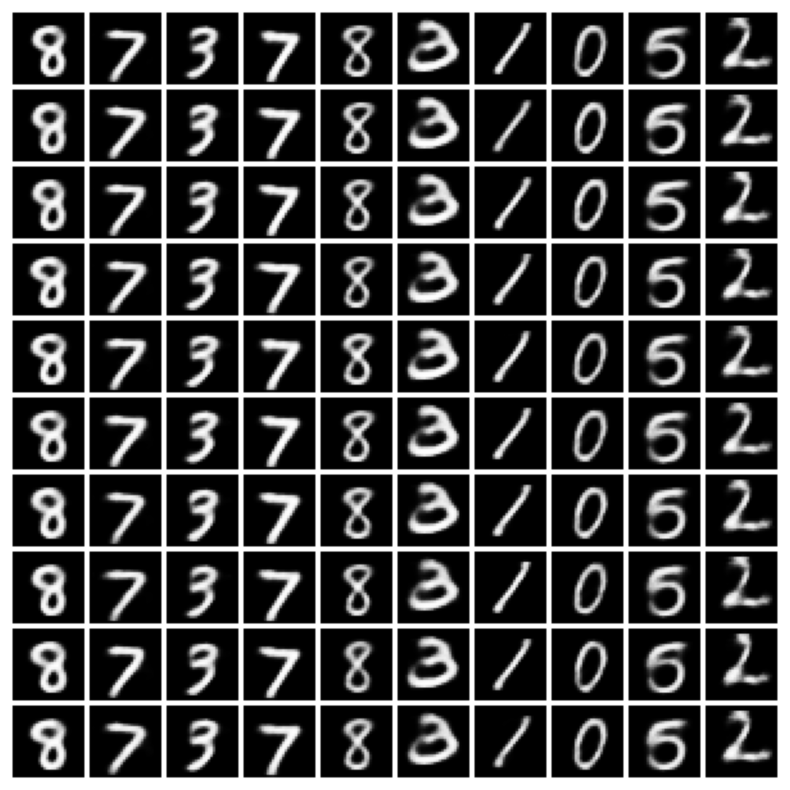

sampled image with larger variance


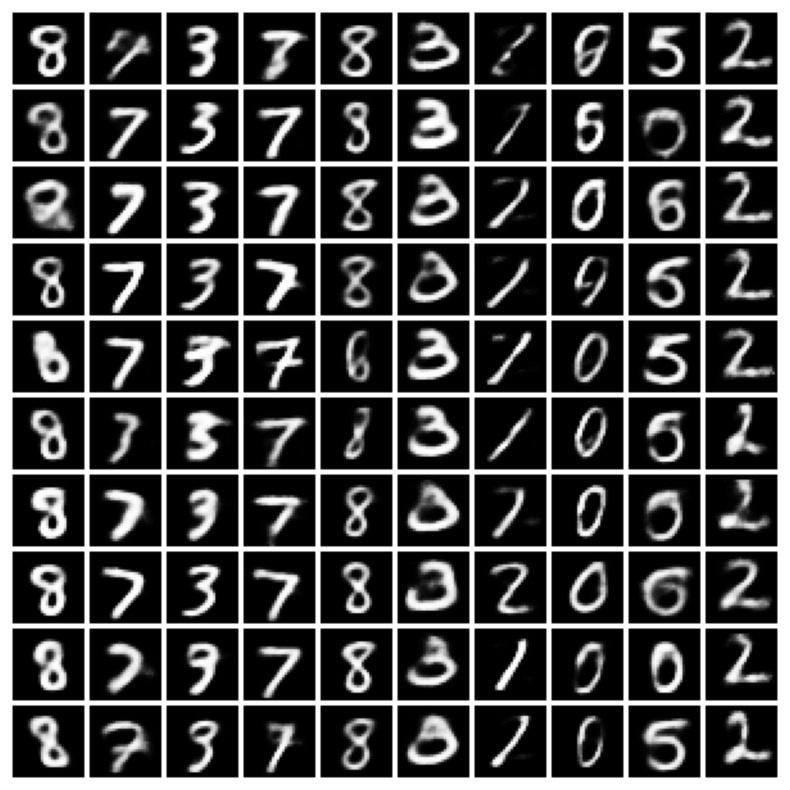

In [35]:
vae.eval()
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10
images = images.repeat(10,1,1,1)

samples, mu, logvar = vae(images.to(device))
# show vae sampled images
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

z = myVAE.reparametrize(mu, logvar+3)
samples = vae.decoder(z)

# show vae sampled images with larger variance
print('sampled image with larger variance')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

# CVAE

In [27]:
cvae = myVAE(input_dim, latent_dim=latent_dim,hidden_dim=hidden_dim, conditional_vec_dim=num_classes).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)

for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      # Calculate the onehot vector based on the label, use the pre-defined function
      # clear the gradients of all optimized variables
      # Forward pass with the one-hot vector
      # calculate the loss using the loss function defined above
      # backward pass: compute gradient of the loss with respect to model parameters
      # perform a single optimization step (parameter update)
      # update running training loss
      data = data.to(device)
      labels = labels.to(device)

      onehot = one_hot(labels, num_classes)
      optimizer.zero_grad()

      out, mu, logvar = cvae(data, onehot)
      loss = torch.mean(cvae.loss_function(out, data, mu, logvar))
      loss.backward()
      optimizer.step()
      train_loss += loss.item()


      pass
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 169.986260
Epoch: 1 	Training Loss: 125.981317
Epoch: 2 	Training Loss: 117.222627
Epoch: 3 	Training Loss: 113.106722
Epoch: 4 	Training Loss: 110.403491
Epoch: 5 	Training Loss: 108.588209
Epoch: 6 	Training Loss: 107.050538
Epoch: 7 	Training Loss: 105.877794
Epoch: 8 	Training Loss: 104.963069
Epoch: 9 	Training Loss: 104.132952


## Results

sampled image


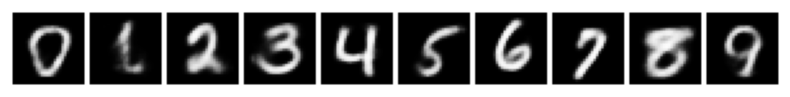

In [28]:
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device)
cvae.eval()
samples = cvae.decoder(z)
# show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

## CVAE + structured output prediction

In [37]:
cvae = myVAE(input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, conditional_vec_dim = portioned_img_size)
cvae.to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)
for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      # Slice the bottom left portion of the image
      # Flatten it/ reshape it to (-1,14*14)
      # clear the gradients of all optimized variables
      # Forward pass with the conditional vector
      # calculate the loss using the loss function defined above
      # backward pass: compute gradient of the loss with respect to model parameters
      # perform a single optimization step (parameter update)
      # update running training loss
      data = data.to(device)
      labels = labels.to(device)
      c = data[:, :, 14:, :14]
      c = c.reshape(-1, portioned_img_size)
      optimizer.zero_grad()
      out, mu, logvar = cvae(data, c)
      loss = torch.mean(cvae.loss_function(out, data, mu, logvar))
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 149.208936
Epoch: 1 	Training Loss: 108.160461
Epoch: 2 	Training Loss: 100.023817
Epoch: 3 	Training Loss: 95.685771
Epoch: 4 	Training Loss: 93.282137
Epoch: 5 	Training Loss: 91.592455
Epoch: 6 	Training Loss: 90.311040
Epoch: 7 	Training Loss: 89.232794
Epoch: 8 	Training Loss: 88.452554
Epoch: 9 	Training Loss: 87.711426


## Baseline NN for structured output prediction

In [77]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        #TODO
        self.input_dim = input_dim
        self.hidden_dim = 400
        self.output_dim = 28*28
        self.sequence = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid(),
            nn.Unflatten(-1, (1, 28, 28))

        )
    def forward(self, z):
        #TODO
        return self.sequence(z)
    

In [78]:
baseline =  BaselineNN(input_dim = portioned_img_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)

for epoch in range(0, n_epochs):
  baseline.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      # Slice the bottom left portion of the image
      # Flatten it/ reshape it to (-1,14*14)
      # clear the gradients of all optimized variables
      # Forward pass with the conditional vector as input
      # calculate the loss using the criterion function defined above
      # backward pass: compute gradient of the loss with respect to model parameters
      # perform a single optimization step (parameter update)
      # update running training loss
      data = data.to(device)
      labels = labels.to(device)
      c = data[:, :, 14:, :14]
      c = c.reshape(-1, portioned_img_size)
      optimizer.zero_grad()
      out = baseline(c)
      
      loss = criterion(out, data)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
  
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.049995
Epoch: 1 	Training Loss: 0.033097
Epoch: 2 	Training Loss: 0.030625
Epoch: 3 	Training Loss: 0.029442
Epoch: 4 	Training Loss: 0.028675
Epoch: 5 	Training Loss: 0.028129
Epoch: 6 	Training Loss: 0.027682
Epoch: 7 	Training Loss: 0.027352
Epoch: 8 	Training Loss: 0.027039
Epoch: 9 	Training Loss: 0.026760


## Results

Ground truth


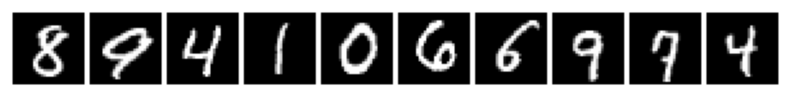

Quarter image


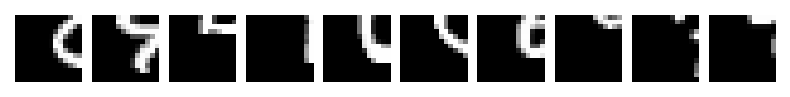

Baseline results


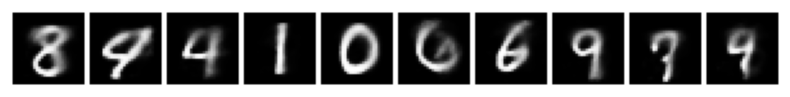

CVAE results


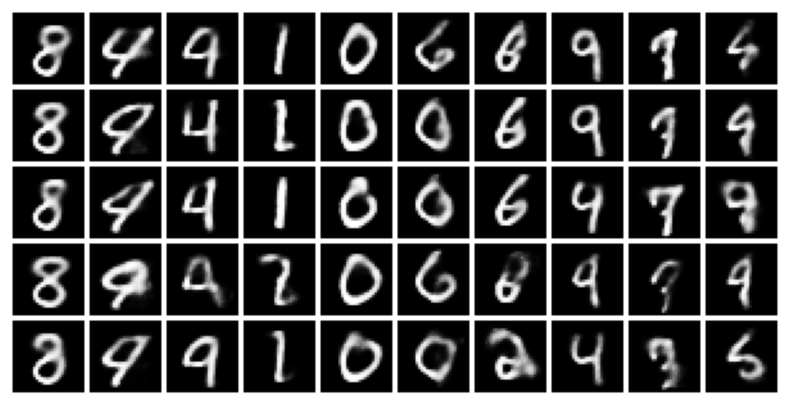

In [79]:
full_imgs = next(iter(loader_test))[0][0:10,:,:,:]
# TODO
# Slice the bottom left portion of the image
quad_imgs = full_imgs[:, :, 14:, :14]
 #(10,1,14,14)

print('Ground truth')
visualize_img_batch(full_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Quarter image')
visualize_img_batch(quad_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Baseline results')
baseline.eval()
samples = baseline(quad_imgs.to(device))
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

print('CVAE results')
cvae.eval()
num_random = 5
quad_imgs = quad_imgs.repeat(num_random ,1,1,1)
quad_imgs = torch.reshape(quad_imgs,(-1, 14*14))

z = torch.randn(num_random*10, latent_dim)
z = torch.cat((z, quad_imgs), dim=-1).to(device) #TODO: concat latent vector with the conditional_vec (quad_imgs)
samples = cvae.decoder(z).data
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()